# WBGT in observations (ISIMIP3a): model eval with obsclim (20y period)

Obsclim 2000-2019, models at same warming level in 20 year period

Also have this preprocessed for 30 year period, could check -> might be more representative!

**Key results:**
- ERA5 gives much lower numbers / WBGT temperatures than W5E5
- Models much more similar to W5E5 than ERA5 (bias adjusted against this I think)
- This seems to be somewhat linked with GMT mapping earlier/later (over-correcting)

**To do**
- check with 30y instead of 20y
- add RMSE in diff maps
- see notes meeting with Wim, eval against nAHD not all WBGT measurements

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


ModuleNotFoundError: No module named 'xarray'

In [ ]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

In [ ]:
from dask.distributed import Client 
client = Client()
client

In [4]:
figdir = os.path.join(figdirs, 'fig_apr24-isimip3a-wbgt')


# Open data obsclim and models 

In [5]:
datasets_sel = datasets[0], datasets[2], datasets[3]

In [6]:
nyrs=20

da_p28_obs, da_p30_obs = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period='present',
                            observations=True,
                            nyrs=nyrs).rename(name) for open_what, name in zip(['pctl28','pctl30'], ['gt28','gt30']) ]

da_mean_obs, da_min_obs, da_max_obs, da_std_obs = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period='present',
                            observations=True,
                            nyrs=nyrs).rename(name) \
                                                   for  open_what, name in zip(
                                                                            ['timmean','timmin', 'timmax', 'timstd'], 
                                                                            ['wbgt_mean','wbgt_min', 'wbgt_max', 'wbgt_std']) ] 



In [7]:


da_p28_mod, da_p30_mod = [ open_all_wbgt_summary(GCMs=GCMs,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment=None,
                            period='present',
                            observations=False,
                            nyrs=nyrs).rename(name) for open_what, name in zip(['pctl28','pctl30'], ['gt28','gt30']) ]

da_mean_mod, da_min_mod, da_max_mod, da_std_mod = [ open_all_wbgt_summary(GCMs=GCMs,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment=None,
                            period='present',
                            observations=False,
                            nyrs=nyrs).rename(name) \
                                                   for  open_what, name in zip(
                                                                            ['timmean','timmin', 'timmax', 'timstd'], 
                                                                            ['wbgt_mean','wbgt_min', 'wbgt_max', 'wbgt_std']) ] 



# 1) Number of days crossing WBGT28 in present-day (2000-2019): models v. obs

Possibly calcuate summary stats only between -40 and 40 lat

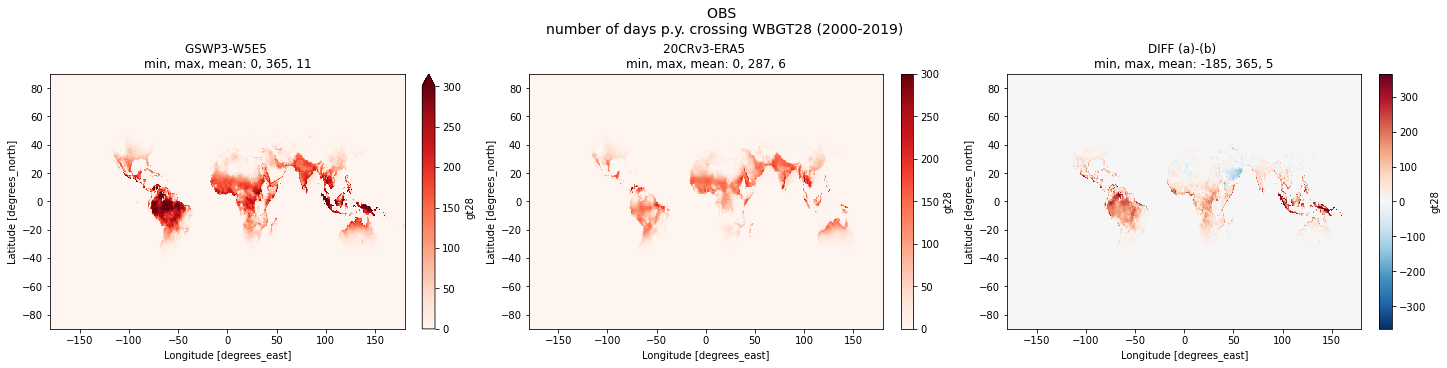

In [44]:
fig, axes = plt.subplots(1,3, figsize=(20,5),  layout='constrained')
axes = axes.flatten() 
vmax=300

for i,ax in enumerate(axes):
    if i < 2:
        data_plot= da_p28_obs.isel(model=i)  * 365
        data_plot.plot(ax=ax, vmax=vmax, cmap='Reds')
        ax.set_title(f'{data_plot.model.values} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')
    if i == 2:
        data_plot= (da_p28_obs.isel(model=0) - da_p28_obs.isel(model=1))  * 365
        data_plot.plot(ax=ax)
        ax.set_title(f'DIFF (a)-(b) \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('OBS \nnumber of days p.y. crossing WBGT28 (2000-2019)',size=14);

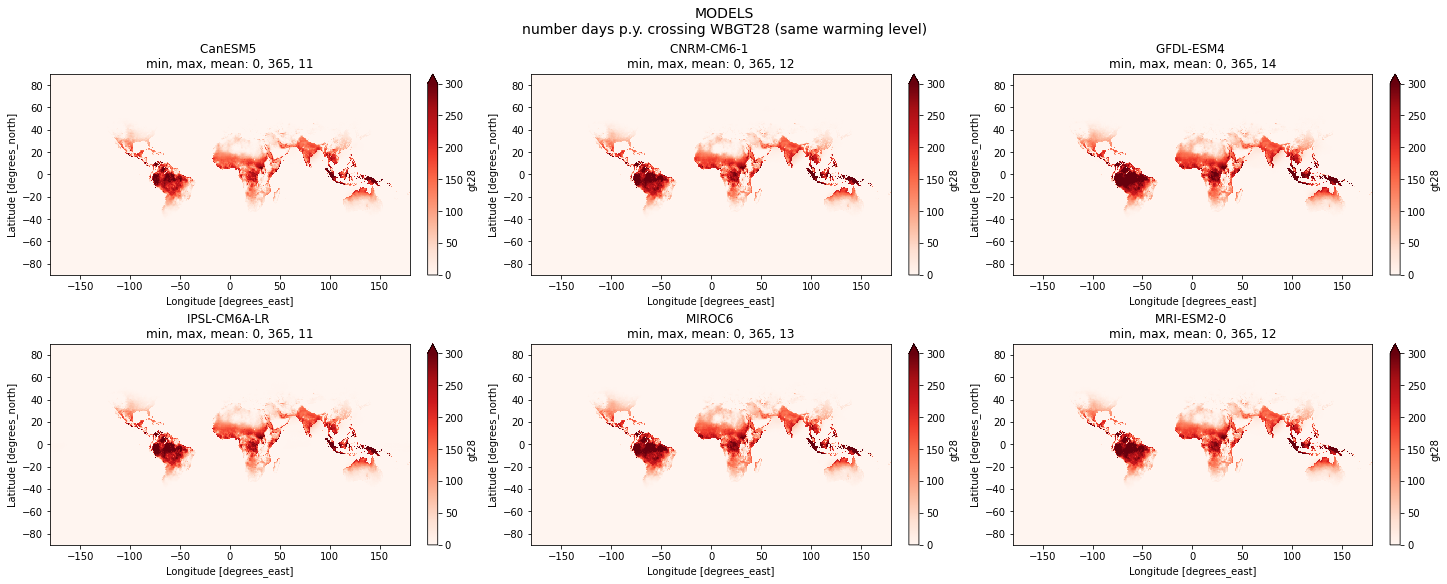

In [24]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax=300

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= da_p28_mod.isel(model=i)  * 365
    data_plot.plot(ax=ax, vmax=vmax, cmap='Reds')
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('MODELS\nnumber days p.y. crossing WBGT28 (same warming level)',size=14);

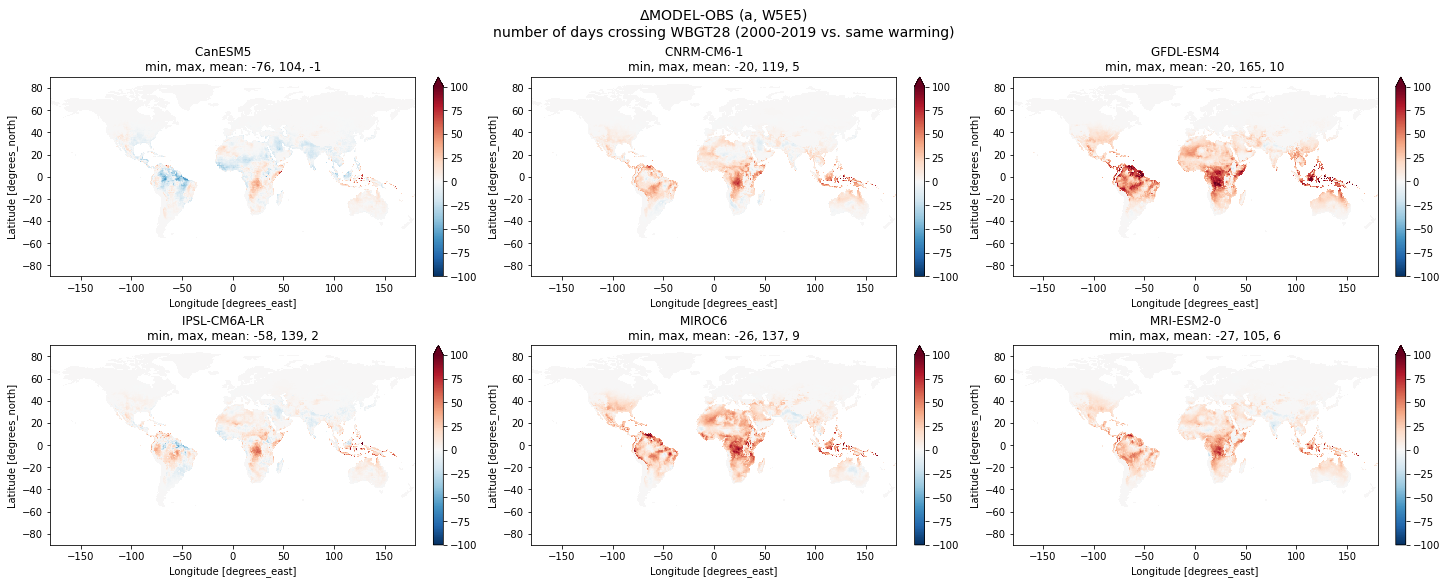

In [48]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_p28_mod.isel(model=i) - da_p28_obs.isel(model=0)) * 365 *landmask
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('$\Delta$MODEL-OBS (a, W5E5) \nnumber of days crossing WBGT28 (2000-2019 vs. same warming)', size=14);

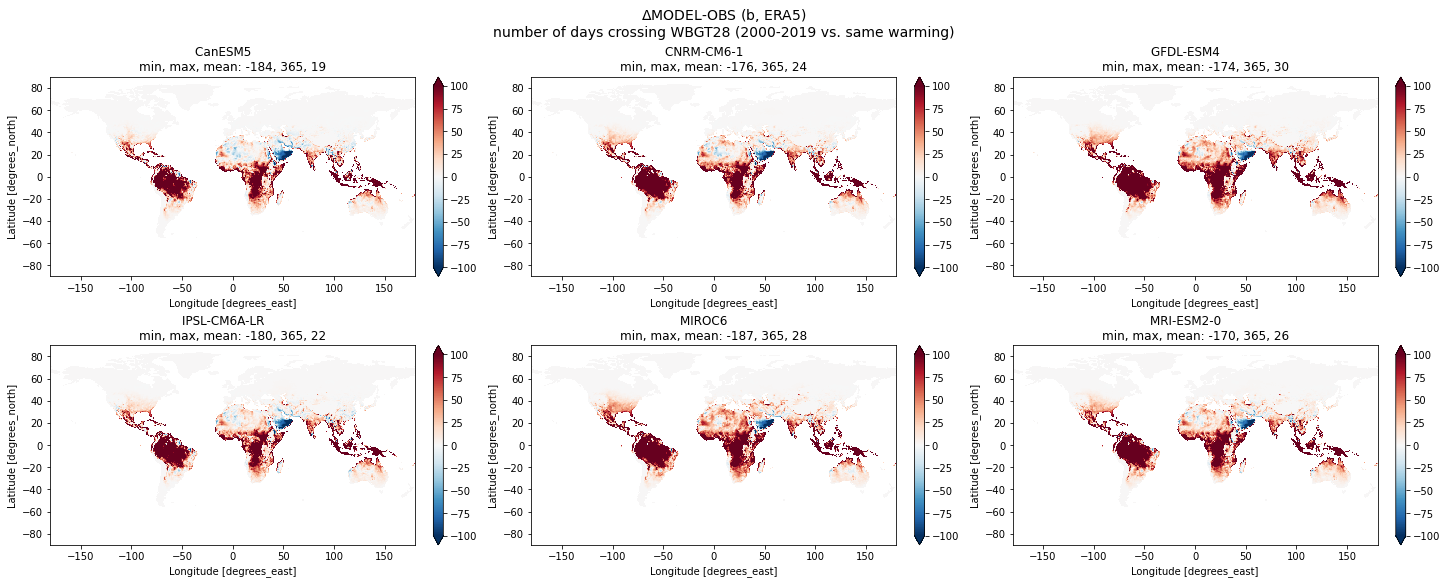

In [46]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_p28_mod.isel(model=i) - da_p28_obs.isel(model=1)) * 365 *landmask
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('$\Delta$MODEL-OBS (b, ERA5) \nnumber of days crossing WBGT28 (2000-2019 vs. same warming)', size=14);

## Times when models were mapped to 

Models mapped further back in past (hot models, CanESM5,IPSL) are possibly over-corrected, and give a bit cold results (CanESM gives cold, IPSL doesn't have a huge systematic bias). 

Models mapped into the future (cold models, GFDL, MIROC) are generally hot in terms of WBGT. 

MRI and CNRM are near the right year and are a bit hot. 

To do:
- compare also mean WBGT and other metrics, not only n of exceedances of 28 

In [164]:
df_gmtmap=pd.read_csv(os.path.join('../../output/output_df-gmt-mapping/df_gmt_mapping_endyear2019_eval.csv'))
df_gmtmap

,model,10_yr,20_yr,30_yr
0,obs,2019,2019,2019
1,CanESM5,2004,2008,2009
2,CNRM-CM6-1,2021,2021,2020
3,GFDL-ESM4,2029,2029,2029
4,IPSL-CM6A-LR,2009,2010,2011
5,MIROC6,2034,2034,2033
6,MRI-ESM2-0,2021,2022,2024


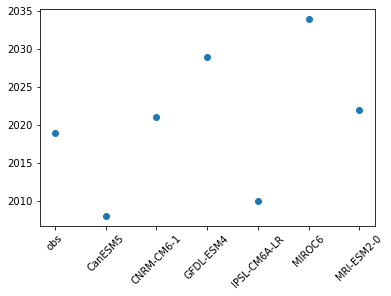

In [179]:
df_gmtmap['20_yr'].plot(linestyle="",marker="o")
plt.xticks(range(7),df_gmtmap.model, rotation=45);

## hist and scatterplot MODELS v. OBS restricted 40 N / 40 S and W5E5

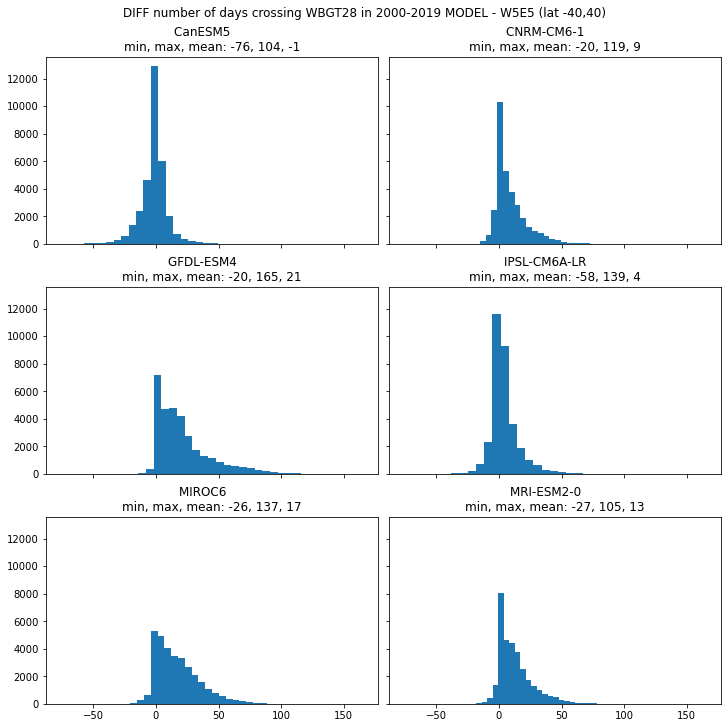

In [188]:
fig, axes = plt.subplots(3,2, figsize=(10,10),  layout='constrained', sharex=True, sharey=True)
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_p28_mod.isel(model=i).sel(lat=slice(40,-40)) - da_p28_obs.isel(model=0)).sel(lat=slice(40,-40)) * 365 * landmask
    data_plot.plot.hist(ax=ax, bins=30)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('DIFF number of days crossing WBGT28 in 2000-2019 MODEL - W5E5 (lat -40,40)');

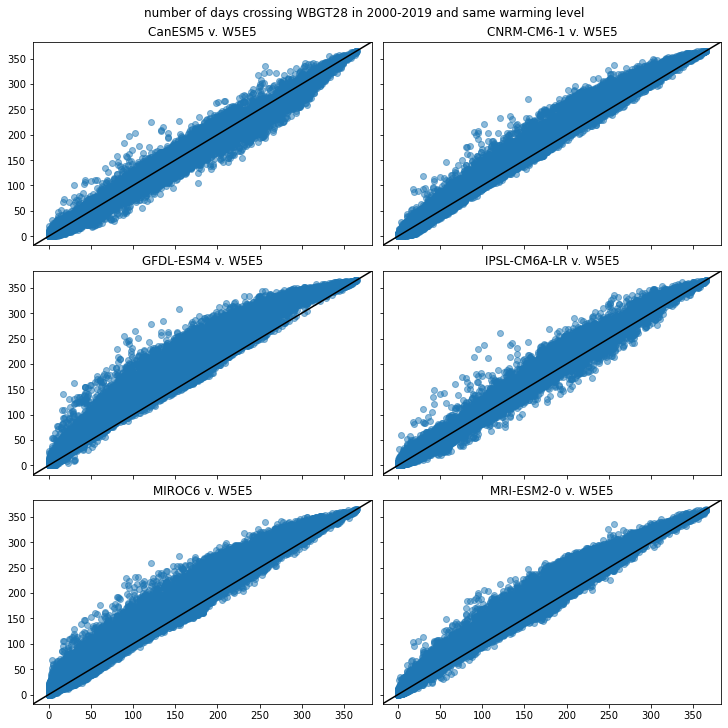

In [189]:
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(3,2, figsize=(10,10),  layout='constrained', sharex=True, sharey=True)
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot1= da_p28_mod.isel(model=i).sel(lat=slice(40,-40))  * 365 * landmask
    data_plot2= da_p28_obs.isel(model=0).sel(lat=slice(40,-40)) * 365 * landmask
    
#     x = data_plot1.values.flatten()
#     y = data_plot2.values.flatten()
#     xy = np.column_stack([x, y])
#     xy=xy[~numpy.isnan(xy).any(axis=1)]
    
#     z = gaussian_kde(xy)(xy)

    ax.scatter(data_plot2, data_plot1, alpha=0.5 ) #c=z
    ax.axline((0,0), slope=1, c='k')
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} v. W5E5')

fig.suptitle('number of days crossing WBGT28 in 2000-2019 and same warming level');

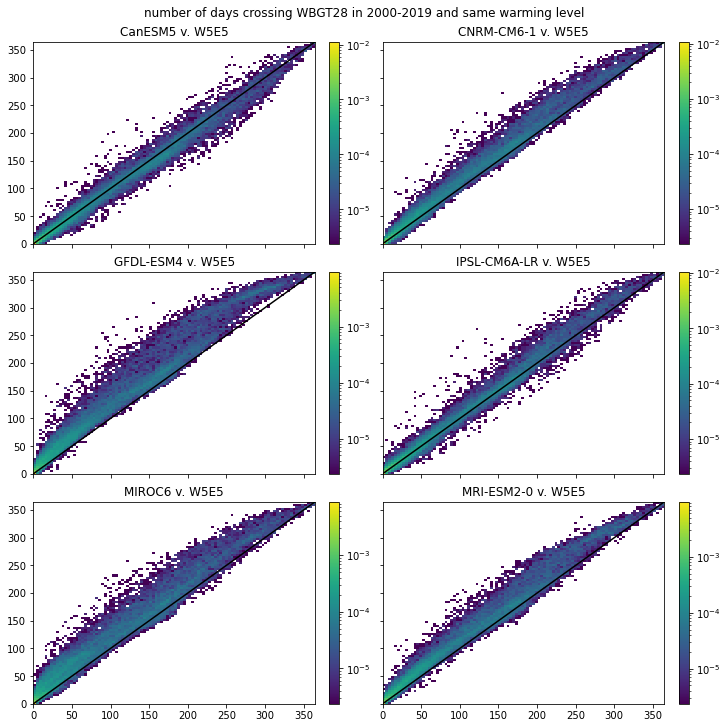

In [185]:
fig, axes = plt.subplots(3,2, figsize=(10,10),  layout='constrained', sharex=True, sharey=True)
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot1= da_p28_obs.isel(model=0).sel(lat=slice(40,-40)) * 365 * landmask
    data_plot2= da_p28_mod.isel(model=i).sel(lat=slice(40,-40))  * 365 * landmask
    
    x = data_plot1.values.flatten()
    y = data_plot2.values.flatten()
    xy = np.column_stack([x, y])
    xy=xy[~numpy.isnan(xy).any(axis=1)]
    
    
    h = ax.hist2d(xy[:,0],xy[:,1],bins=100,density=True, norm=colors.LogNorm())
    

    ax.axline((0,0), slope=1, c='k')
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} v. W5E5')

    fig.colorbar(h[3], ax=ax)
fig.suptitle('number of days crossing WBGT28 in 2000-2019 and same warming level');

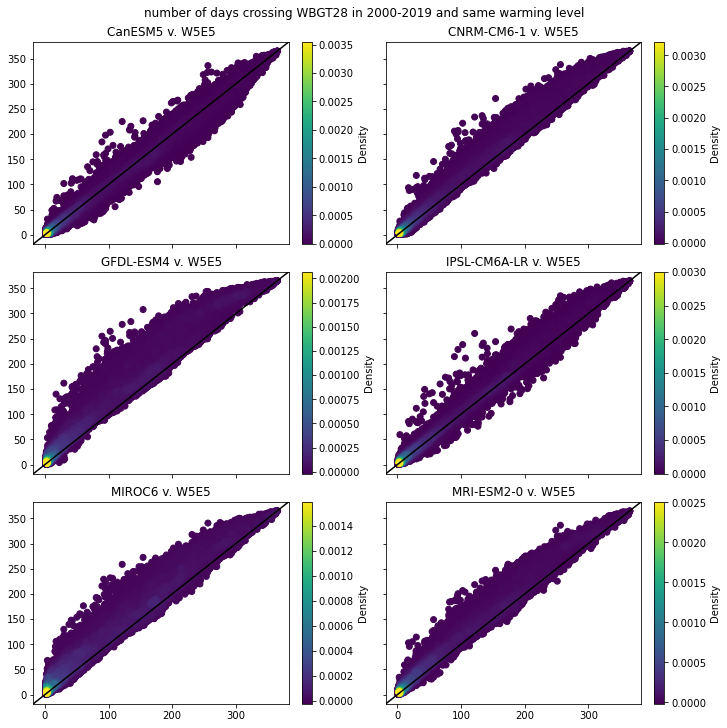

In [186]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = plt.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

fig, axes = plt.subplots(3,2, figsize=(10,10),  layout='constrained', sharex=True, sharey=True)
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot1= da_p28_obs.isel(model=0).sel(lat=slice(40,-40)) * 365 * landmask
    data_plot2= da_p28_mod.isel(model=i).sel(lat=slice(40,-40))  * 365 * landmask
    
    # stack and remove nan values
    x = data_plot1.values.flatten()
    y = data_plot2.values.flatten()
    xy = np.column_stack([x, y])
    xy=xy[~numpy.isnan(xy).any(axis=1)]
    
    #get only values above 1 
    xy = xy[np.all(xy >1, axis=1)]
    
    density_scatter(xy[:,0],xy[:,1],bins=[100,100],ax=ax)
    

    ax.axline((0,0), slope=1, c='k')
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} v. W5E5')

fig.suptitle('number of days crossing WBGT28 in 2000-2019 and same warming level');

# 2) Mean WBGT

Biases generally within +/- 2 degrees 

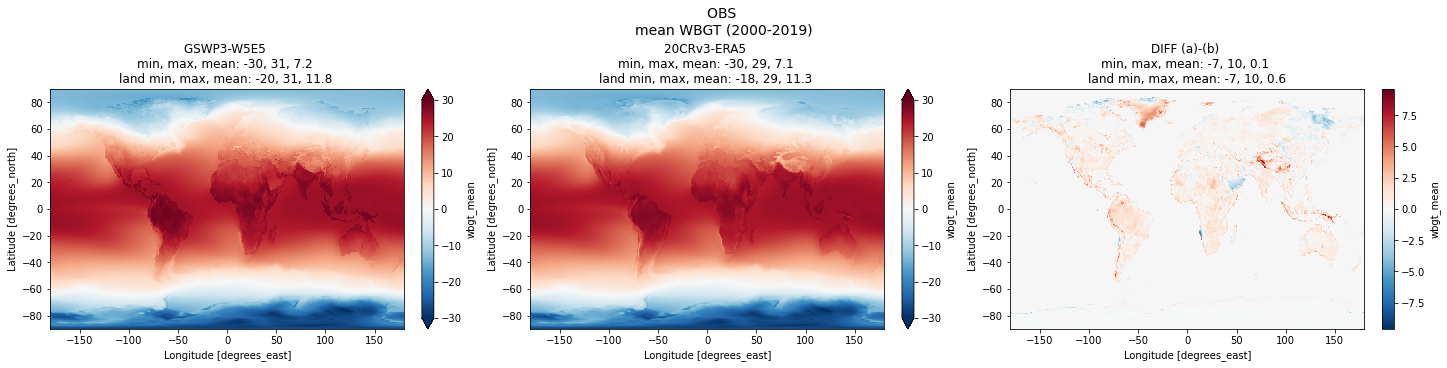

In [206]:
fig, axes = plt.subplots(1,3, figsize=(20,5),  layout='constrained')
axes = axes.flatten() 
vmax=30

for i,ax in enumerate(axes):
    if i < 2:
        data_plot= da_mean_obs.isel(model=i)
        data_plot.plot(ax=ax,vmax=vmax,extend='both')
        ax.set_title(f'{data_plot.model.values} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.1f} \nland min, max, mean: {(data_plot*landmask).min().item():.0f}, {(data_plot*landmask).max().item():.0f}, {(data_plot*landmask).mean().item():.1f} ')
    if i == 2:
        data_plot= (da_mean_obs.isel(model=0) - da_mean_obs.isel(model=1)) 
        data_plot.plot(ax=ax)
        ax.set_title(f'DIFF (a)-(b) \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.1f} \nland min, max, mean: {(data_plot*landmask).min().item():.0f}, {(data_plot*landmask).max().item():.0f}, {(data_plot*landmask).mean().item():.1f}')

fig.suptitle('OBS \nmean WBGT (2000-2019)',size=14);

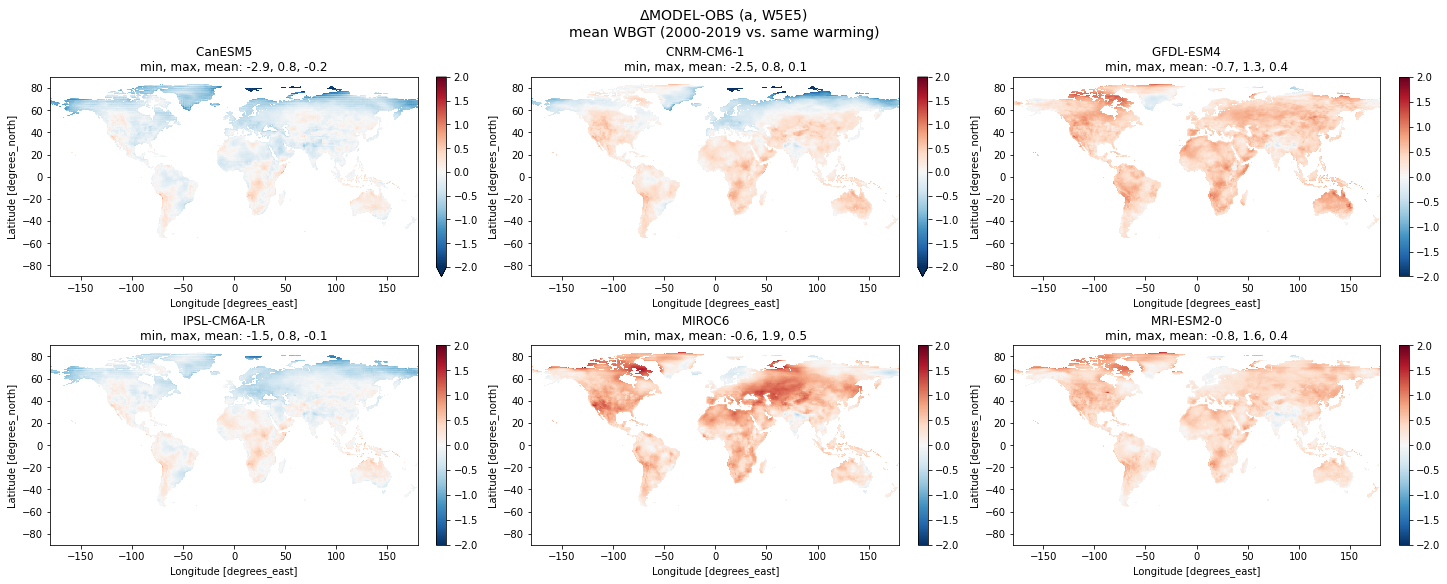

In [217]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax=2
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_mean_mod.isel(model=i) - da_mean_obs.isel(model=0)) *landmask
    data_plot.plot(ax=ax,vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.1f}, {data_plot.max().item():.1f}, {data_plot.mean().item():.1f}')

fig.suptitle('$\Delta$MODEL-OBS (a, W5E5) \nmean WBGT (2000-2019 vs. same warming)', size=14);

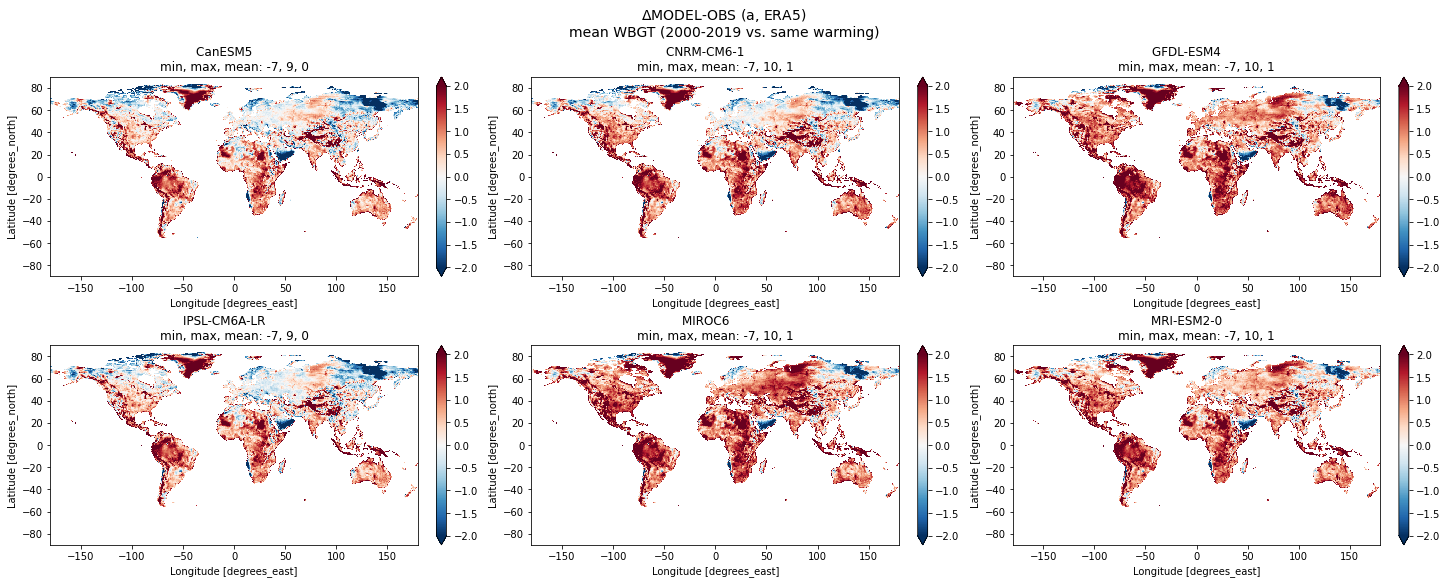

In [216]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax=2
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_mean_mod.isel(model=i) - da_mean_obs.isel(model=1)) *landmask
    data_plot.plot(ax=ax,vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('$\Delta$MODEL-OBS (a, ERA5) \nmean WBGT (2000-2019 vs. same warming)', size=14);

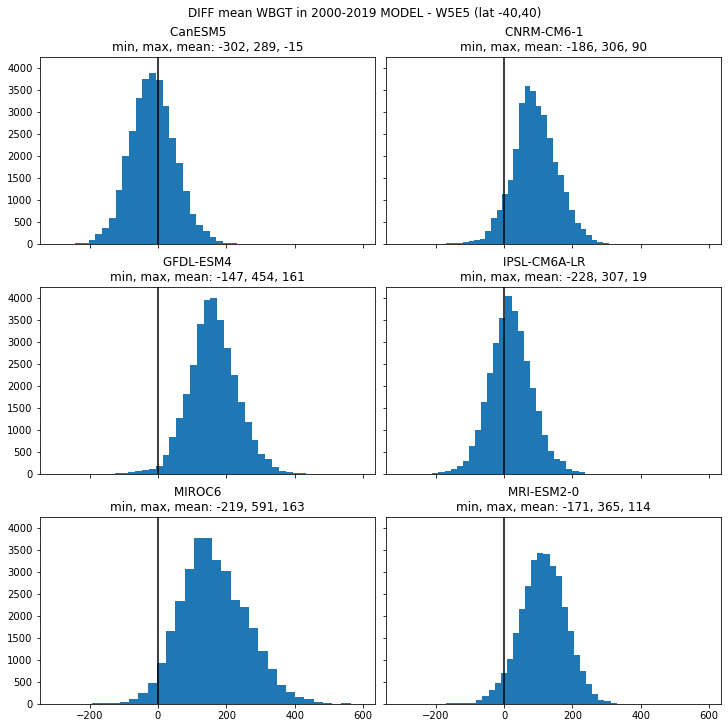

In [222]:
fig, axes = plt.subplots(3,2, figsize=(10,10),  layout='constrained', sharex=True, sharey=True)
axes = axes.flatten() 
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_mean_mod.isel(model=i).sel(lat=slice(40,-40)) - da_mean_obs.isel(model=0)).sel(lat=slice(40,-40)) * 365 * landmask
    data_plot.plot.hist(ax=ax, bins=30)
    ax.axvline(0,c='k')
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('DIFF mean WBGT in 2000-2019 MODEL - W5E5 (lat -40,40)');